In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from seaborn import heatmap

from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats import diagnostic as diag

plt.style.use('ggplot')

# Cleaning the data

dataset = pd.read_excel("mas_car_00_18_2019_adjusted.xlsx")

df = dataset[['Date Announced', 'Original Date Announced', 'Standard Industry Classification Code',
            'Same_industry', 'CAR(-1, +1)', 'CAR(-2, 2)', 'crossborderdeal', 'cashpayment', 'leverage',
            'Acquiror Market Value 4 Weeks Prior to Announcement ($mil).1', 'Deal Attitude', 'Deal Status',
            'Percentage of Shares Acquired', 'TPUBLIC', 'Target Market Value 4 Weeks Prior to Announcment ($mil)']]
df['Date (years)'] = pd.to_datetime(df['Date Announced'], format="%Y%m%d").dt.year

# rename the columns
column_mapping = {'Standard Industry Classification Code': 'SIC',
            'Same_industry': 'HORIZ', 'CAR(-2, 2)': 'CAR(-2, +2)',
            'crossborderdeal': 'CROSS', 'cashpayment': 'CASH', 'leverage': 'LEV',
            'Acquiror Market Value 4 Weeks Prior to Announcement ($mil).1': 'Acq_size',
            'TPUBLIC': 'Tar. Private', 'Target Market Value 4 Weeks Prior to Announcment ($mil)': 'DSIZE'}

df = df.rename(mapper=column_mapping, axis=1)

# drop date announced, original date announced
df = df.drop(['Date Announced', 'Original Date Announced'], axis=1)

# save new dataframe as a .csv file
df.to_csv('ARP_compressed_dataset.csv', index=False)

for col in dataset.columns:
    print(col)

# Filtering the sample

In [2]:
# reimport the data set
df = pd.read_csv('ARP_compressed_dataset.csv')
df

,SIC,HORIZ,"CAR(-1, +1)","CAR(-2, +2)",CROSS,CASH,LEV,Acq_size,Deal Attitude,Deal Status,Percentage of Shares Acquired,Tar. Private,DSIZE,Date (years)
0,5961,0,-0.001608,0.009858,0,0,0.456346,140.433,Friendly,Completed,36,Priv.,NaN,2013
1,5961,0,-0.018310,-0.034374,1,1,0.4521884,555.630,Friendly,Completed,100,Priv.,NaN,2008
2,5961,0,-0.007620,-0.015071,1,1,0.344419,426.282,Friendly,Completed,100,Sub.,NaN,2006
3,5961,0,0.211841,0.146537,1,1,0.3044112,330.046,Friendly,Completed,100,Public,137.544,2014
4,6020,0,0.001937,0.048450,1,0,0.9189009,57.730,Friendly,Completed,100,Priv.,NaN,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20371,6211,1,0.027444,0.020493,1,0,0.7598003,1333.872,Friendly,Pending,.,Sub.,NaN,2008
20372,6211,0,0.100135,0.151409,1,0,0.7244874,667.857,Friendly,Completed,100,Priv.,NaN,2009
20373,6211,0,0.039568,0.030297,1,0,0.7128826,1446.661,Friendly,Completed,100,Priv.,NaN,2007
20374,7372,0,-0.029043,0.003318,1,0,0.295371,355.064,Friendly,Completed,100,Priv.,NaN,2006


In [3]:
# categorise deals in terms of deal attitude
# remove deal attitude that is not applicable and unsolicit
df = df.loc[df['Deal Attitude'] != 'Not Appl.']
df = df.loc[df['Deal Attitude'] != 'Unsolic.']

# assign 1 to friendly deals and 0 to other deals
df.loc[:, 'Deal Attitude'].replace(to_replace={'Friendly': 1, 'Neutral': 0, 'Hostile': 0}, inplace=True)
df.reset_index(inplace=True, drop=True)

In [4]:
# assign 1 to private targets and 0 to other public status
df.loc[:, 'Tar. Private'].replace(to_replace={'Priv.': 1, 'Sub.': 0, 'Public': 0, 'J.V.': 0, 'Govt.': 0}, inplace=True)
df.reset_index(inplace=True, drop=True)

In [5]:
# convert data in acquired ownership into float
df = df[df['Percentage of Shares Acquired'] != '.']
df['Percentage of Shares Acquired'] = df['Percentage of Shares Acquired'].astype(np.float64)

In [6]:
# only select the completed deals
df = df.loc[df['Deal Status'] == 'Completed']
print(f"The number of observations is: {df.shape[0]}")

# only select the deals that over 50% ownership is acquired
df = df.loc[df['Percentage of Shares Acquired'] >= 50]
print(f"The number of observations is: {df.shape[0]}")

# only select the deals with non-null target market value
df = df.loc[df['DSIZE'].notnull()]
print(f"The number of observations is: {df.shape[0]}")

# drop these two columns
df.drop(columns=['Deal Status', 'Percentage of Shares Acquired'], inplace=True)

The number of observations is: 16871
The number of observations is: 16086
The number of observations is: 1227


In [7]:
# categorise high-tech companies in terms of the SIC code
# 3-digit optimal SIC code in Kile and Phillips (2009)
df['SIC'] = df['SIC'].astype(str)

high_tech_sic = [283, 357, 366, 367, 382, 384, 481, 482, 489, 737, 873]
ht_df = pd.DataFrame()

for sic in high_tech_sic:    
    ht_df = pd.concat([ht_df, df[df['SIC'].str.startswith(f'{sic}')]])

ht_df.reset_index(inplace=True, drop=True)

In [8]:
# only select the deals from 2006 to 2017
ht_df = ht_df.loc[(ht_df['Date (years)'] >= 2005) & (ht_df['Date (years)'] <= 2017)]

# delete unnecessary columns (SIC, Date)
ht_df = ht_df.drop(['SIC', 'Deal Attitude'], axis=1)

# reset the index
ht_df = ht_df.reset_index(drop=True)

In [9]:
# change the dtype of column 'LEV'
ht_df = ht_df.drop(ht_df.loc[ht_df['LEV'] == '.'].index)
ht_df['LEV'] = ht_df['LEV'].astype(float)
ht_df = ht_df.reset_index(drop=True)

In [10]:
# calculate the relative size of each transaction
ht_df['RSIZE'] = ht_df['DSIZE'] / ht_df['Acq_size']

In [11]:
# smooth the acq_size and deal size to their log value
ht_df['Acq_size'] = np.log(ht_df.Acq_size)
ht_df['DSIZE'] = np.log(ht_df.DSIZE)

In [12]:
# reorder the column
ht_df = ht_df[[
    'Date (years)', 'CAR(-1, +1)', 'CAR(-2, +2)', 'CROSS', 'CASH',
    'HORIZ', 'DSIZE', 'RSIZE', 'LEV', 'Acq_size', 'Tar. Private'
    ]]

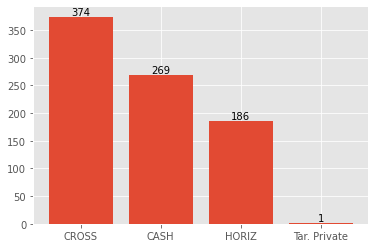

In [13]:
# visualise the distribution of categorical variables
x = ['CROSS', 'CASH', 'HORIZ', 'Tar. Private']
y = [ht_df[n].sum() for n in x]

plt.bar(x, y)
for i in range(len(y)):
    plt.annotate(str(y[i]), xy=(x[i], y[i]), ha='center', va='bottom')

plt.show()

In [14]:
# drop Tar.private
ht_df.drop(['Tar. Private'], axis=1, inplace=True)

In [15]:
ht_df['VERT'] = np.where(ht_df.HORIZ == 0, 1, 0)
ht_df

,Date (years),"CAR(-1, +1)","CAR(-2, +2)",CROSS,CASH,HORIZ,DSIZE,RSIZE,LEV,Acq_size,VERT
0,2015,-0.059092,-0.068087,1,1,0,9.439383,0.138620,0.936763,11.415402,1
1,2009,0.004792,0.055386,1,1,0,5.816590,0.004191,0.536660,11.291327,1
2,2014,-0.008882,0.011462,0,0,1,7.476291,0.030198,0.436201,10.976277,0
3,2010,0.018298,-0.007777,1,1,0,6.090807,0.005342,0.563140,11.322900,1
4,2009,-0.002918,-0.009315,0,0,0,4.188305,0.000795,0.571191,11.326012,1
...,...,...,...,...,...,...,...,...,...,...,...
447,2008,-0.014172,-0.030753,0,0,0,6.651629,0.024593,0.242955,10.356906,1
448,2007,0.010579,0.018269,1,0,0,3.241185,0.043071,0.693630,6.386089,1
449,2006,-0.059281,-0.080870,1,1,0,3.414837,0.053428,0.603128,6.344249,1
450,2006,0.024441,0.032589,1,1,0,0.501381,0.024208,0.645392,4.222474,1


In [16]:
ht_df.to_csv('ARP_ht_data.csv', index=False)
ht_df

,Date (years),"CAR(-1, +1)","CAR(-2, +2)",CROSS,CASH,HORIZ,DSIZE,RSIZE,LEV,Acq_size,VERT
0,2015,-0.059092,-0.068087,1,1,0,9.439383,0.138620,0.936763,11.415402,1
1,2009,0.004792,0.055386,1,1,0,5.816590,0.004191,0.536660,11.291327,1
2,2014,-0.008882,0.011462,0,0,1,7.476291,0.030198,0.436201,10.976277,0
3,2010,0.018298,-0.007777,1,1,0,6.090807,0.005342,0.563140,11.322900,1
4,2009,-0.002918,-0.009315,0,0,0,4.188305,0.000795,0.571191,11.326012,1
...,...,...,...,...,...,...,...,...,...,...,...
447,2008,-0.014172,-0.030753,0,0,0,6.651629,0.024593,0.242955,10.356906,1
448,2007,0.010579,0.018269,1,0,0,3.241185,0.043071,0.693630,6.386089,1
449,2006,-0.059281,-0.080870,1,1,0,3.414837,0.053428,0.603128,6.344249,1
450,2006,0.024441,0.032589,1,1,0,0.501381,0.024208,0.645392,4.222474,1


# Separate the sample
- Cross border deals 
- National deals 

Analyse sub-samples descriptive statistics in terms of company characteristics

In [17]:
# split the sample
cross_df = ht_df[ht_df.CROSS == 1]
national_df = ht_df[ht_df.CROSS == 0]

In [18]:
# show the descriptive statistics for each one
cross_des = cross_df.drop(['Date (years)', 'CAR(-2, +2)', 'CROSS'], axis=1).describe()
cross_des.to_clipboard()

cross_des

,"CAR(-1, +1)",CASH,HORIZ,DSIZE,RSIZE,LEV,Acq_size,VERT
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,-0.007172,0.590909,0.441176,5.605409,0.510757,0.474866,8.530977,0.558824
std,0.072925,0.492325,0.497193,2.017028,5.978594,0.264066,2.319889,0.497193
min,-0.330750,0.000000,0.000000,-3.194183,0.000011,0.034233,0.564177,0.000000
25%,-0.035539,0.000000,0.000000,4.244865,0.015800,0.312079,6.712953,0.000000
50%,-0.002862,1.000000,0.000000,5.682663,0.067847,0.455397,8.437853,1.000000
75%,0.022443,1.000000,1.000000,6.973771,0.230231,0.602052,10.372869,1.000000
max,0.264029,1.000000,1.000000,10.781452,115.630830,2.758185,13.213017,1.000000


In [19]:
national_des = national_df.drop(['Date (years)', 'CAR(-2, +2)', 'CROSS'], axis=1).describe()
national_des.to_clipboard()

national_des

,"CAR(-1, +1)",CASH,HORIZ,DSIZE,RSIZE,LEV,Acq_size,VERT
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,0.014908,0.615385,0.269231,5.140672,0.165313,0.439731,8.142257,0.730769
std,0.065130,0.489653,0.446431,1.876765,0.287192,0.212259,2.111666,0.446431
min,-0.138915,0.000000,0.000000,0.416735,0.000795,0.068770,1.800389,0.000000
25%,-0.013988,0.000000,0.000000,3.669448,0.016345,0.262420,6.921015,0.000000
50%,0.010067,1.000000,0.000000,5.190001,0.071166,0.454853,8.086329,1.000000
75%,0.028367,1.000000,1.000000,6.469375,0.200453,0.574811,9.535363,1.000000
max,0.270624,1.000000,1.000000,9.419559,1.982565,1.018791,12.673011,1.000000


In [20]:
# test for multicollinearity
X1 = sm.tools.add_constant(ht_df.drop(['Date (years)', 'CAR(-2, +2)'], axis=1))
vif = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index=X1.columns)
vif_df = vif.to_frame()
vif_df.to_clipboard()

vif_df

/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,0
const,0.000000
"CAR(-1, +1)",1.064336
CROSS,1.049123
CASH,1.206563
HORIZ,inf
DSIZE,1.620182
RSIZE,1.066855
LEV,1.043334
Acq_size,1.910800
VERT,inf


# Empirical analysis
- Univariate test
- Multivariate test

## Univariate test

In [21]:
# t-test for cross-border and domestic samples
cross = ht_df['CAR(-1, +1)'].loc[ht_df['CROSS'] == 1]
domestic = ht_df['CAR(-1, +1)'].loc[ht_df['CROSS'] == 0]
one_day_car_cross = ttest_ind(x1=cross, x2=domestic, usevar='unequal')

print(f"""
    The t-statistics is: {one_day_car_cross[0]:.3f}
    The p-value is: {one_day_car_cross[1] / 2:.3f}
    The degree of freedom is {one_day_car_cross[2]:.3f}
    """)


    The t-statistics is: -2.666
    The p-value is: 0.004
    The degree of freedom is 120.824
    


In [22]:
cross = ht_df['CAR(-2, +2)'].loc[ht_df['CROSS'] == 1]
domestic = ht_df['CAR(-2, +2)'].loc[ht_df['CROSS'] == 0]
two_day_car_cross = ttest_ind(x1=cross, x2=domestic, usevar='unequal')

print(f"""
    The t-statistics is: {two_day_car_cross[0]:.3f}
    The p-value is: {two_day_car_cross[1] / 2:.3f}
    The degree of freedom is {two_day_car_cross[2]:.3f}""")


    The t-statistics is: -2.430
    The p-value is: 0.008
    The degree of freedom is 114.575


In [23]:
# t-test for cash and non-cash observations
cash = ht_df['CAR(-1, +1)'].loc[ht_df['CASH'] == 1]
non_cash = ht_df['CAR(-1, +1)'].loc[ht_df['CASH'] == 0]
one_day_car_cash = ttest_ind(x1=cash, x2=non_cash, usevar='unequal')

print(f"""
    The t-statistics is: {one_day_car_cash[0]:.3f}
    The p-value is: {one_day_car_cash[1] / 2:.3f}
    The degree of freedom is {one_day_car_cash[2]:.3f}""")


    The t-statistics is: 2.015
    The p-value is: 0.022
    The degree of freedom is 256.145


In [24]:
cash = ht_df['CAR(-2, +2)'].loc[ht_df['CASH'] == 1]
non_cash = ht_df['CAR(-2, +2)'].loc[ht_df['CASH'] == 0]
two_day_car_cash = ttest_ind(x1=cash, x2=non_cash, usevar='unequal')

print(f"""
    The t-statistics is: {one_day_car_cash[0]:.3f}
    The p-value is: {one_day_car_cash[1] / 2:.3f}
    The degree of freedom is {one_day_car_cash[2]:.3f}""")


    The t-statistics is: 2.015
    The p-value is: 0.022
    The degree of freedom is 256.145


## Mutivariate test

In [25]:
# descriptive statistics of the sample
descriptive_df = ht_df.describe()

# save the table
descriptive_df.to_csv('tables_for_use/descriptive_statistics.csv')

descriptive_df

,Date (years),"CAR(-1, +1)","CAR(-2, +2)",CROSS,CASH,HORIZ,DSIZE,RSIZE,LEV,Acq_size,VERT
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000
mean,2010.194690,-0.003361,-0.004979,0.827434,0.595133,0.411504,5.525211,0.451145,0.468803,8.463897,0.588496
std,3.073695,0.072058,0.082718,0.378291,0.491410,0.492651,1.999261,5.439938,0.256008,2.287801,0.492651
min,2005.000000,-0.330750,-0.368057,0.000000,0.000000,0.000000,-3.194183,0.000011,0.034233,0.564177,0.000000
25%,2008.000000,-0.028850,-0.032935,1.000000,0.000000,0.000000,4.190056,0.015947,0.301691,6.740203,0.000000
50%,2010.000000,-0.002362,-0.003933,1.000000,1.000000,0.000000,5.602198,0.068305,0.455397,8.337667,1.000000
75%,2013.000000,0.023812,0.027444,1.000000,1.000000,1.000000,6.901908,0.220401,0.594697,10.280310,1.000000
max,2016.000000,0.270624,0.315561,1.000000,1.000000,1.000000,10.781452,115.630830,2.758185,13.213017,1.000000


In [26]:
# correlation matirx of the sample
correlation_df = ht_df.drop(['CAR(-2, +2)', 'Date (years)'], axis=1).corr()

# save the table
correlation_df.to_csv('tables_for_use/correlation.csv')

correlation_df

,"CAR(-1, +1)",CROSS,CASH,HORIZ,DSIZE,RSIZE,LEV,Acq_size,VERT
"CAR(-1, +1)",1.000000,-0.115914,0.104763,0.133021,0.079656,-0.086554,-0.011162,0.115587,-0.133021
CROSS,-0.115914,1.000000,-0.018841,0.132031,0.087935,0.024022,0.051917,0.064275,-0.132031
CASH,0.104763,-0.018841,1.000000,-0.042998,0.048006,-0.078159,-0.074334,0.342946,0.042998
HORIZ,0.133021,0.132031,-0.042998,1.000000,0.090335,-0.040476,-0.003052,-0.011091,-1.000000
DSIZE,0.079656,0.087935,0.048006,0.090335,1.000000,0.009495,0.114411,0.577462,-0.090335
RSIZE,-0.086554,0.024022,-0.078159,-0.040476,0.009495,1.000000,-0.016261,-0.184838,0.040476
LEV,-0.011162,0.051917,-0.074334,-0.003052,0.114411,-0.016261,1.000000,0.148323,0.003052
Acq_size,0.115587,0.064275,0.342946,-0.011091,0.577462,-0.184838,0.148323,1.000000,0.011091
VERT,-0.133021,-0.132031,0.042998,-1.000000,-0.090335,0.040476,0.003052,0.011091,1.000000


<AxesSubplot:>

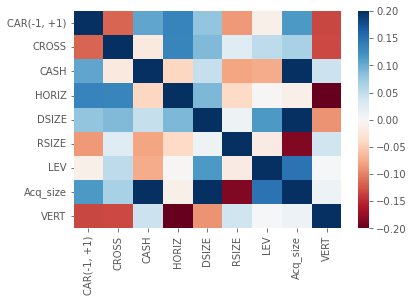

In [27]:
heatmap(correlation_df, cmap='RdBu', vmin=-0.2, vmax=0.2)

In [28]:
# multilinear regression of 1-day CAR - all variables
y = ht_df['CAR(-1, +1)']
X = ht_df.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)', 'HORIZ'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

results.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CAR(-1, +1)   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     4.081
Date:                Fri, 20 Aug 2021   Prob (F-statistic):           0.000235
Time:                        15:10:25   Log-Likelihood:                 562.12
No. Observations:                 452   AIC:                            -1108.
Df Residuals:                     444   BIC:                            -1075.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.016      0.067      0.947      -0.030       0.032
CROSS         -0.0266      0.009     -2.998      0.003      -0.044      -0.009
CASH           0.0113      0.007      1.535      0.126      -0.003       0.026
DSIZE          0.0013      0.002      0.624      0.533      -0.003       0.005
RSIZE         -0.0008      0.001     -1.239      0.216      -0.002       0.000
LEV           -0.0037      0.013     -0.280      0.779      -0.030       0.022
Acq_size       0.0022      0.002      1.098      0.273      -0.002       0.006
VERT          -0.0219      0.007     -3.201      0.001      -0.035      -0.008
==============================================================================
Omnibus:                       53.415   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              349.324
Skew:                           0.183   Prob(JB):                     1.40e-76
Kurtosis:                       7.291   Cond. No.                         55.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
# multilinear regression of 1-day CAR - control variables
y = ht_df['CAR(-1, +1)']
X = ht_df.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)', 'CASH', 'HORIZ', 'VERT'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CAR(-1, +1)   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.149
Date:                Fri, 20 Aug 2021   Prob (F-statistic):            0.00834
Time:                        15:11:54   Log-Likelihood:                 555.87
No. Observations:                 452   AIC:                            -1100.
Df Residuals:                     446   BIC:                            -1075.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0129      0.015     -0.844      0.399      -0.043       0.017
CROSS         -0.0233      0.009     -2.619      0.009      -0.041      -0.006
DSIZE          0.0015      0.002      0.720      0.472      -0.003       0.006
RSIZE         -0.0009      0.001     -1.413      0.158      -0.002       0.000
LEV           -0.0068      0.013     -0.511      0.610      -0.033       0.019
Acq_size       0.0029      0.002      1.537      0.125      -0.001       0.006
==============================================================================
Omnibus:                       50.054   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              316.560
Skew:                           0.124   Prob(JB):                     1.82e-69
Kurtosis:                       7.092   Cond. No.                         52.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
# multilinear regression of 2-day CAR
y = ht_df['CAR(-2, +2)']
X = ht_df.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)', 'HORIZ'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

results.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CAR(-2, +2)   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     4.074
Date:                Fri, 20 Aug 2021   Prob (F-statistic):           0.000240
Time:                        15:10:26   Log-Likelihood:                 499.74
No. Observations:                 452   AIC:                            -983.5
Df Residuals:                     444   BIC:                            -950.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0102      0.018      0.558      0.577      -0.026       0.046
CROSS         -0.0283      0.010     -2.777      0.006      -0.048      -0.008
CASH           0.0151      0.008      1.785      0.075      -0.002       0.032
DSIZE          0.0011      0.002      0.436      0.663      -0.004       0.006
RSIZE         -0.0005      0.001     -0.633      0.527      -0.002       0.001
LEV           -0.0277      0.015     -1.824      0.069      -0.058       0.002
Acq_size       0.0025      0.002      1.072      0.284      -0.002       0.007
VERT          -0.0241      0.008     -3.067      0.002      -0.040      -0.009
==============================================================================
Omnibus:                       41.902   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.395
Skew:                          -0.156   Prob(JB):                     1.12e-44
Kurtosis:                       6.263   Cond. No.                         55.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
# add interaction variables
# CROSS * VERT
vert_interact = ht_df.copy()
vert_interact['CROSS * VERT'] = vert_interact.CROSS * vert_interact.VERT
vert_interact

y = vert_interact['CAR(-1, +1)']
X = vert_interact.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)', 'CASH', 'HORIZ'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

results.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CAR(-1, +1)   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     3.755
Date:                Fri, 20 Aug 2021   Prob (F-statistic):           0.000575
Time:                        15:12:46   Log-Likelihood:                 561.03
No. Observations:                 452   AIC:                            -1106.
Df Residuals:                     444   BIC:                            -1073.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0076      0.020      0.389      0.698      -0.031       0.046
CROSS           -0.0331      0.016     -2.017      0.044      -0.065      -0.001
DSIZE            0.0007      0.002      0.358      0.721      -0.003       0.005
RSIZE           -0.0008      0.001     -1.221      0.223      -0.002       0.000
LEV             -0.0065      0.013     -0.492      0.623      -0.032       0.019
Acq_size         0.0034      0.002      1.845      0.066      -0.000       0.007
VERT            -0.0292      0.018     -1.618      0.106      -0.065       0.006
CROSS * VERT     0.0087      0.020      0.446      0.656      -0.030       0.047
==============================================================================
Omnibus:                       50.003   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              315.336
Skew:                           0.125   Prob(JB):                     3.36e-69
Kurtosis:                       7.084   Cond. No.                         106.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# CROSS * CASH
cash_interact = ht_df.copy()
cash_interact['CROSS * CASH'] = cash_interact.CROSS * cash_interact.CASH
cash_interact

y = cash_interact['CAR(-1, +1)']
X = cash_interact.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)', 'HORIZ'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

results.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CAR(-1, +1)   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     3.761
Date:                Fri, 20 Aug 2021   Prob (F-statistic):           0.000281
Time:                        15:13:52   Log-Likelihood:                 562.88
No. Observations:                 452   AIC:                            -1108.
Df Residuals:                     443   BIC:                            -1071.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0137      0.019      0.724      0.469      -0.024       0.051
CROSS           -0.0402      0.014     -2.825      0.005      -0.068      -0.012
CASH            -0.0067      0.017     -0.407      0.684      -0.039       0.026
DSIZE            0.0012      0.002      0.573      0.567      -0.003       0.005
RSIZE           -0.0008      0.001     -1.213      0.226      -0.002       0.000
LEV             -0.0028      0.013     -0.213      0.832      -0.029       0.023
Acq_size         0.0021      0.002      1.040      0.299      -0.002       0.006
VERT            -0.0225      0.007     -3.286      0.001      -0.036      -0.009
CROSS * CASH     0.0221      0.018      1.220      0.223      -0.014       0.058
==============================================================================
Omnibus:                       52.888   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              344.360
Skew:                           0.174   Prob(JB):                     1.67e-75
Kurtosis:                       7.262   Cond. No.                         95.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# CROSS * RSIZE
rsize_interact = ht_df.copy()
rsize_interact['CROSS * RSIZE'] = rsize_interact.CROSS * rsize_interact.RSIZE
rsize_interact

y = rsize_interact['CAR(-1, +1)']
X = rsize_interact.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)', 'HORIZ', 'CASH', 'VERT'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

results.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CAR(-1, +1)   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.751
Date:                Fri, 20 Aug 2021   Prob (F-statistic):             0.0123
Time:                        15:14:56   Log-Likelihood:                 556.26
No. Observations:                 452   AIC:                            -1099.
Df Residuals:                     445   BIC:                            -1070.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0073      0.017     -0.441      0.660      -0.040       0.025
CROSS            -0.0276      0.010     -2.718      0.007      -0.048      -0.008
DSIZE             0.0019      0.002      0.880      0.379      -0.002       0.006
RSIZE            -0.0265      0.029     -0.906      0.366      -0.084       0.031
LEV              -0.0066      0.013     -0.495      0.621      -0.033       0.020
Acq_size          0.0024      0.002      1.274      0.203      -0.001       0.006
CROSS * RSIZE     0.0256      0.029      0.875      0.382      -0.032       0.083
==============================================================================
Omnibus:                       50.557   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              323.416
Skew:                           0.127   Prob(JB):                     5.90e-71
Kurtosis:                       7.136   Cond. No.                         133.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model diagnostics - Checking for heteroscedasticity

In [44]:
# White test
# OLS for CAR(-1, +1)
y = ht_df['CAR(-1, +1)']
X = ht_df.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)', 'HORIZ'], axis=1)
X = sm.add_constant(X)

model = sm.GLS(y, X)  # use GLS instead
results = model.fit()

# Run the White's test
_, pval, __, f_pval = diag.het_white(results.resid, results.model.exog)
print(pval, f_pval)
print('-'*100)

# print the results of the test
if pval > 0.05:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity. \n")
    
else:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypthoesis, so there is heterosecdasticity. \n")

# Run the Breusch-Pagan test
_, pval, __, f_pval = diag.het_breuschpagan(results.resid, results.model.exog)
print(pval, f_pval)
print('-'*100)

# print the results of the test
if pval > 0.05:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity.")

else:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypthoesis, so there is heterosecdasticity.")



4.4070221090536015e-10 1.002531682132411e-11
----------------------------------------------------------------------------------------------------
For the White's Test
The p-value was 4.407e-10
We reject the null hypthoesis, so there is heterosecdasticity. 

9.013668104296279e-11 1.6014408572065358e-11
----------------------------------------------------------------------------------------------------
For the Breusch-Pagan's Test
The p-value was 9.014e-11
We reject the null hypthoesis, so there is heterosecdasticity.


/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# Engle LM test
# OLS for CAR(-1, +1)
y = ht_df['CAR(-1, +1)']
X = ht_df.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

# Run the White's test
_, pval, __, f_pval = diag.het_arch(results.resid)
print(pval, f_pval)
print('-'*100)

# print the results of the test
if pval > 0.05:
    print("For the Engle LM Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity. \n")
    
else:
    print("For the Engle LM Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypthoesis, so there is heterosecdasticity. \n")

0.8738049755238525 0.8803409988450657
----------------------------------------------------------------------------------------------------
For the Engle LM Test
The p-value was 0.8738
We fail to reject the null hypthoesis, so there is no heterosecdasticity. 



/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:657: FutureWarning: The default value of nlags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setmaxlags or period to silence this warning.
  warnings.warn("The default value of nlags is changing.  After 0.12, "


In [ ]:
# Engle LM test
# OLS for CAR(-2, +2)
y = ht_df['CAR(-2, +2)']
X = ht_df.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

# Run the White's test
_, pval, __, f_pval = diag.het_arch(results.resid)
print(pval, f_pval)
print('-'*100)

# print the results of the test
if pval > 0.05:
    print("For the Engle LM Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity. \n")
    
else:
    print("For the Engle LM Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypthoesis, so there is heterosecdasticity. \n")

0.5975828239674805 0.6055213746001327
----------------------------------------------------------------------------------------------------
For the Engle LM Test
The p-value was 0.5976
We fail to reject the null hypthoesis, so there is no heterosecdasticity. 

